# Region of Interest (ROI) Extraction from ORIGA dataset images

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
base_dir = '../data/ORIGA/Images'
files = os.listdir(base_dir)
file = os.path.join(base_dir, files[0])
img = cv.imread(file)
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Method 1: Intensity weighted centroid

weights.shape = (2048, 2518), x.shape = (2048, 2518), y.shape = (2048, 2518)
weights.min() = 0.0, weights.max() = 5.7345017e-07
x_mean = 1387.1760171078183, y_mean = 1045.7225606529853


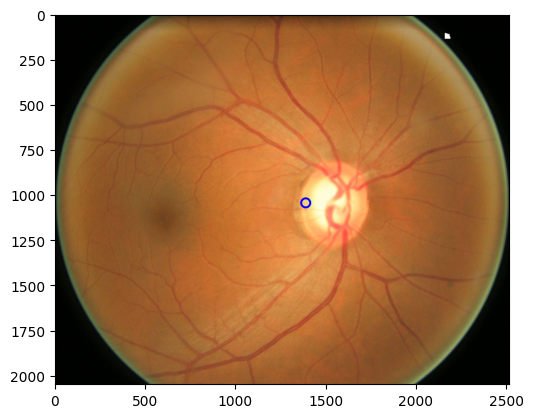

In [9]:
def intensity_weighted_centroid(image):
    weights = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Equalize histogram to increase contrast
    weights = cv.equalizeHist(weights)

    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    # clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # weights = clahe.apply(weights)

    # Convert to float32 and normalize
    weights = weights.astype(np.float32)
    weights -= weights.min()
    weights = weights / weights.max()

    # Apply Gaussian blur to smooth out the image
    # k_size = 65
    # weights = cv.GaussianBlur(weights, (k_size, k_size), 0)

    # Square the weights to increase the contrast
    weights = weights ** 2
    weights = weights / weights.sum()

    # Cut off the bottom % of the weights
    weights[weights < np.quantile(weights, 0.85)] = 0

    # Find the centroid
    x = np.arange(0, weights.shape[1])
    y = np.arange(0, weights.shape[0])
    x, y = np.meshgrid(x, y)
    x_weighted = x * weights
    y_weighted = y * weights
    x_mean = np.sum(x_weighted) / np.sum(weights)
    y_mean = np.sum(y_weighted) / np.sum(weights)

    print(f'{weights.shape = }, {x.shape = }, {y.shape = }')
    print(f'{weights.min() = }, {weights.max() = }')
    print(f'{x_mean = }, {y_mean = }')

    # Add line to weights indicating the centroid
    # x_weighted[:, int(x_mean)] = np.max(x_weighted)
    # y_weighted[int(y_mean), :] = np.max(y_weighted)

    # _, ax = plt.subplots(2, 3, figsize=(15, 8))
    # ax = ax.ravel()
    # ax[0].imshow(x)
    # ax[1].imshow(y)
    # ax[2].imshow(weights)
    # ax[3].imshow(x_weighted)
    # ax[4].imshow(y_weighted)
    # ax[5].imshow(img[..., ::-1])
    # plt.show()

    return x_mean, y_mean


cent4er = intensity_weighted_centroid(img)
res = cv.circle(img.copy(), (int(cent4er[0]), int(cent4er[1])), 25, (255, 0, 0), 10)
plt.imshow(res[..., ::-1])
plt.show()

## Method 2: Brightest spot algorithm

max_val = 0.9777779, max_idx = array([ 997., 1511.])
cx = 1511.0, cy = 997.0


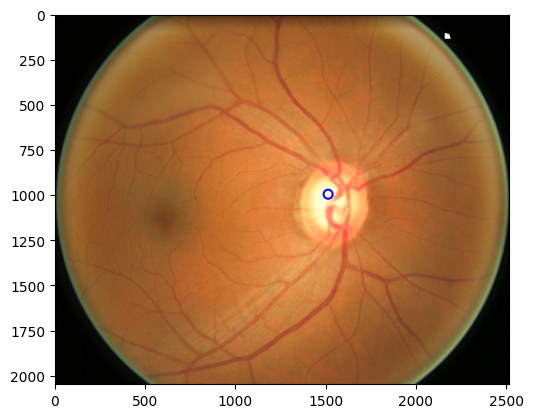

In [13]:
def brightest_spot(image):
    grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    grey = grey.astype(np.float32)
    grey = grey / 255

    # Apply Gaussian blur to smooth out the image
    k_size = 65
    blurred_img = cv.GaussianBlur(grey, (k_size, k_size), 0)

    # Find the brightest spot
    max_val = np.max(blurred_img)
    max_idx = np.where(blurred_img == max_val)

    # Average the brightest spots in case there are multiple
    max_idx = np.mean(max_idx, axis=1)

    # Find the centroid of the brightest spot
    cx = np.mean(max_idx[1])
    cy = np.mean(max_idx[0])

    print(f'{max_val = }, {max_idx = }')
    print(f'{cx = }, {cy = }')

    return cx, cy


center = brightest_spot(img)
res = cv.circle(img.copy(), (int(center[0]), int(center[1])), 25, (255, 0, 0), 10)
plt.imshow(res[..., ::-1])
plt.show()

## Method 3: Circular Hough Transform

cx = 1337.6875, cy = 1056.0


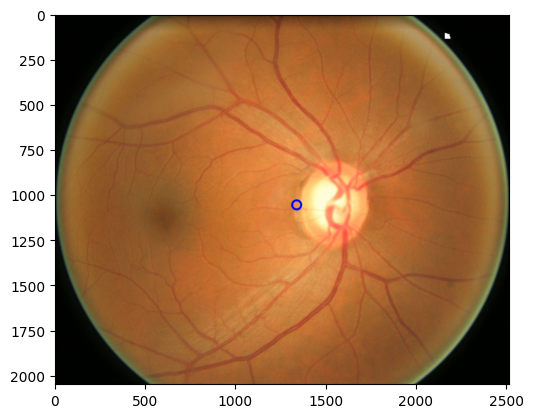

In [40]:
def circular_hough_transform(image):
    grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Resize
    org_shape = grey.shape
    new_shape = (256, 256)
    grey = cv.resize(grey, new_shape)

    # Apply Gaussian blur to smooth out the image
    k_size = 65
    blurred_img = cv.GaussianBlur(grey, (k_size, k_size), 0)

    # Apply Canny edge detection
    canny = cv.Canny(blurred_img, 0.5, 1)

    # Apply Circular Hough Transform
    circles = cv.HoughCircles(
        canny, cv.HOUGH_GRADIENT, dp=1, minDist=50, param1=100, param2=30, minRadius=30, maxRadius=150)
    circles = np.uint16(np.around(circles))

    # Find the centroid of the brightest spot
    cx = circles[0, 0, 0]
    cy = circles[0, 0, 1]

    # Rescale the centroid to the original image size
    cx = cx * org_shape[1] / new_shape[1]
    cy = cy * org_shape[0] / new_shape[0]

    print(f'{cx = }, {cy = }')

    return cx, cy


center = circular_hough_transform(img)
res = cv.circle(img.copy(), (int(center[0]), int(center[1])), 25, (255, 0, 0), 10)
plt.imshow(res[..., ::-1])
plt.show()


## Method 4: Edge and Contour Detection

cx = 280.8171506352087, cy = 243.98298548094374


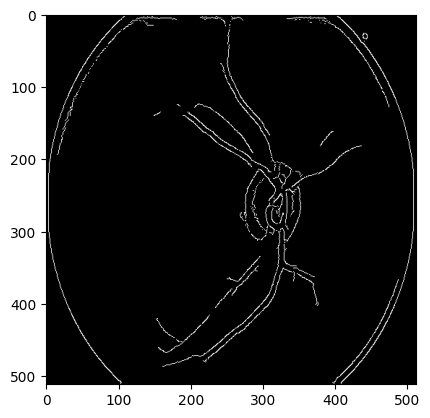

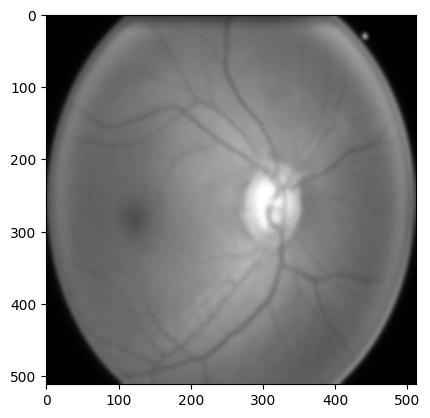

In [35]:
# Load the fundus image
image = img.copy()
image = cv.resize(image, (512, 512))

# Convert the image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply blur to reduce noise
k_size = 15
blurred_image = cv.GaussianBlur(gray_image, (k_size, k_size), 0)

# Apply Canny edge detection
canny = cv.Canny(blurred_image, threshold1=10, threshold2=30)

# Find average point of the contours
contours, _ = cv.findContours(
    canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = np.vstack(contours)
contours = np.squeeze(contours)
cx = np.mean(contours[:, 0])
cy = np.mean(contours[:, 1])
print(f'{cx = }, {cy = }')

plt.imshow(canny, cmap='gray')
plt.show()
plt.imshow(blurred_image, cmap='gray')
plt.show()

## Method 5: Template Matching

## Method 6: Morphological Operations

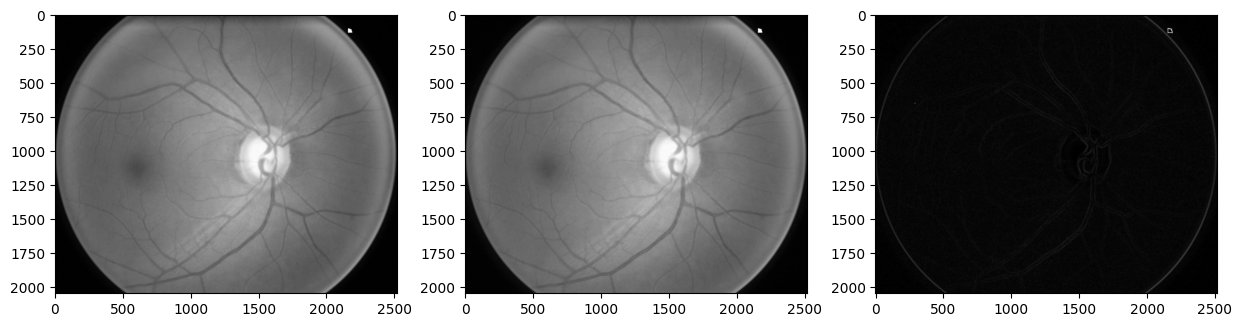

In [55]:
# Opening and closing
kernel = np.ones((5, 5), np.uint8)
opening = cv.morphologyEx(grey_img, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(grey_img, cv.MORPH_CLOSE, kernel)

# Gradient
gradient = cv.morphologyEx(grey_img, cv.MORPH_GRADIENT, kernel)

# Plot
_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax = ax.ravel()
ax[0].imshow(opening, cmap='gray')
ax[1].imshow(closing, cmap='gray')
ax[2].imshow(gradient, cmap='gray')
plt.show()

## Method 7: Deep Learning